In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
from tqdm import *

In [ ]:
##### LOAD DATA INSTEAD OF RUNNING THIS #############################################
# Create "body_skill.csv": csv containging unique, non-nan bodies and associated skill

# load pre-selected dataset
df3 = pd.read_csv('../../data/df3.csv')

# get unique problem text
body = df3['body'].unique()
body.shape

# Confirm that, yes, some problems have the same text
dfsub = df3[['problem_id','body']].drop_duplicates(subset='problem_id')
dfbody = dfsub.groupby('body').count()
# dfbody is how many different problem ids each body is associated with

# Begin processing to get skills for each (I know this is inefficeint...)
body_small = body

body_skill = [] # list of all skills, in orders
body_edited = []
for problem in tqdm(body_small):
    if isinstance(problem, str):
        body_edited.append(problem)
        skill = df3[df3['body'] == problem]['skill_name'].iloc[0] # get the first skill associated with the assistment
        body_skill.append(skill)
        
# save above
body_save=pd.DataFrame({'body': body_edited,
  'skill_name': body_skill})
body_save.to_csv('../../data/body_skill_v2.csv',sep='\t',index=False,columns=['body','skill_name'])

In [ ]:
###### LOAD DATA ########
df = pd.read_csv('../../data/body_skill.csv', sep='\t')
body = df['body'].values
skills = df['skill_name'].values


In [ ]:
body_small = body
print(type(body_small))
body_small.shape

def removeHTML(x):
    # Remove not useful characters and HTML text
    x = re.sub('<.*?>', '', x)
    x = re.sub('\n', ' ', x)
    x = re.sub('&nbsp;', '', x)
    x = re.sub('\?', '', x)
    x = re.sub('\\.(\\s)', ' ', x)
    x = re.sub(',', '', x)
    x = re.sub(':', '', x)
    x = re.sub(';', ' ', x)
    x = re.sub('\(', '', x)
    x = re.sub('\)', '', x)
    return x

# Make list of lists of words in each problem
problems = []   # list of lists of words in each problem
wordsAll = []   # list of all words (duplicate words listed more than once)
wordsPerProblem = Counter() # count of how many different problems each word occurred in
for problem in tqdm(body_small):
    if isinstance(problem, str):
        text = removeHTML(problem.lower()) # remove HTML text
        words = text.split() # split into words at white space
        wordsPerProblem += Counter(set(words))
        wordsAll += words
        problems.append(words)
        #print(Counter(set(words)).most_common(), '\n\n')
    
print(len(wordsAll))
print(wordsPerProblem.most_common(20))

In [ ]:
# Look at the most common words in the dataset
commonWords = list(np.array(Counter(wordsAll).most_common(50))[:,0])
print(commonWords)

In [ ]:
# Create dictionary based on highedt average TFIDF
N = len(problems)
print('Total Number of problems: ',N)

vs = 512 # vocab size
dWordsAll = dict(Counter(wordsAll))
dWordsProb = dict(wordsPerProblem)
dDivide = {k: dWordsAll[k]/N*np.log(N/dWordsProb[k]) for k in dWordsProb.keys() & dWordsAll }
c = Counter(dDivide)
wordDict = list(np.array(c.most_common(vs))[:,0])
print(wordDict)

In [ ]:
# TF-IDF
# tf_ij: number of times word i appears in problem j
# df_i: number of problems containing word i
# N: number of problems

problems_small = problems
N = float(len(problems))
print('Number of problems: ',N)

tfidf = []
for problem in tqdm(problems_small):
    c = Counter(problem)
    tfidf_row = []
    for word in wordDict:
        tfidf_row.append(c[word]*np.log(N/wordsPerProblem[word]))
    tfidf.append(np.array(tfidf_row))
    
tfidf = np.array(tfidf)
plt.figure(figsize=(14,14))
plt.imshow(tfidf[::50,:])
plt.colorbar()
plt.clim((0,5))


In [ ]:
print(tfidf.shape)

In [ ]:
# run tsne
tsne=TSNE(perplexity=30,verbose=2) #Instantiate the TSNE model (can change params here)
tfidf_tsne=tsne.fit_transform(xviz) #Run tsne

tsne_save=pd.DataFrame({'x': tfidf_tsne[:,0],
  'y': tfidf_tsne[:,1],
  'skill' : skills_viz})
tsne_save.to_csv('../d3-scatterplot/tsne_body_bagofwords.tsv',sep='\t',index=False,columns=['x','y','skill'])


In [ ]:
tfidf_tsne.shape

## Visualization Set

## Bag of Words Autoencoder

(18110, 512)
(2013, 512)
(18110,)
(2013,)


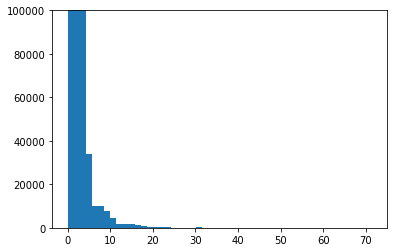

In [43]:
# split bag of words data into training and testing set
xtrain = []
xtest =[]
skills_train = []
skills_test = []
for i in np.arange(tfidf.shape[0]):
    if np.mod(i,10) == 0:
        xtest.append(tfidf[i,:])
        skills_test.append(skills[i])
    else:
        xtrain.append(tfidf[i,:])
        skills_train.append(skills[i])
        
xtrain = np.stack(xtrain, axis=0)
xtest = np.stack(xtest, axis=0)
skills_train = np.stack(skills_train, axis=0)
skills_test = np.stack(skills_test, axis=0)
print(xtrain.shape)
print(xtest.shape)
print(skills_train.shape)
print(skills_test.shape)

# Create visualization set (no nans)
xviz = []
skills_viz = []
for i in np.arange(1,tfidf.shape[0]):
    if isinstance(skills[i],str):
        xviz.append(tfidf[i,:])
        skills_viz.append(skills[i])
        
xviz = np.stack(xviz, axis=0)
skills_viz = np.stack(skills_viz, axis=0)

plt.hist(np.ndarray.flatten(tfidf), bins=50)
plt.ylim([0, 100000])

norm = 20 # normalization
xtrain = xtrain/norm
xtest = xtest/norm
xviz = xviz/norm

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = Input(shape=(vs,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(vs, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(32,))
# retrieve the last layers of the autoencoder model
decoder_layers = autoencoder.layers[-3](encoded_input)
decoder_layers = autoencoder.layers[-2](decoder_layers)
decoder_layers = autoencoder.layers[-1](decoder_layers)
# create the decoder model
decoder = Model(encoded_input, decoder_layers)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(xtrain, xtrain,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(xtest, xtest))

In [44]:
encoded = encoder.predict(xviz)
encoded.shape

(13348, 32)

In [64]:
# SAVE autoencoder output #
print (xviz.shape)
print (len(skills_viz))
print (encoded.shape)
np.savez('autoencoder_output.npz', xviz=xviz, skills_viz=skills_viz, encoded=encoded)

(13348, 512)
13348
(13348, 32)


In [45]:
# Test decoder
auto = autoencoder.predict(xviz)
decoded = decoder.predict(encoded)
print(np.max(np.abs(auto[1,:]-decoded[1,:])))

0.0


In [ ]:
tsne=TSNE(perplexity=30,verbose=2) #Instantiate the TSNE model (can change params here)
tfidf_tsne=tsne.fit_transform(encoded) #Run tsne
tsne_save=pd.DataFrame({'x': tfidf_tsne[:,0],
  'y': tfidf_tsne[:,1],
  'skill' : skills_viz})
#tsne_save=pd.DataFrame({'x': encoded[:,0],
#  'y': encoded[:,1],
#  'skill' : skills_viz})
tsne_save.to_csv('../d3-scatterplot/tsne_bagofwords_autoencoder.tsv',sep='\t',index=False,columns=['x','y','skill'])


In [ ]:
xpred = autoencoder.predict(xviz)
plt.figure(figsize=(14,8))
n = 1000
plt.plot(xviz[n,:])
plt.plot(xpred[n,:], '--')
#print(xpred[n,:])

## Clustering

In [66]:
## Read in data ##
# xviz - tfidf encodings for all problems that have associated skills
# skills_viz - skill associated with each problem (list)
# encoded - autoencoder output for all problems in xviz
data = np.load('autoencoder_output.npz')
xviz = data['xviz']
skills_viz = data['skills_viz']
encoded = data['encoded']


['encoded', 'skills_viz', 'xviz']


In [ ]:
from sklearn.cluster import KMeans

NC = 32 # number of clusters for K-means
kmeanse = KMeans(n_clusters=NC).fit(encoded)
kmeansb = KMeans(n_clusters=NC).fit(xviz) #bag of words encoding


In [ ]:
labelse = kmeanse.labels_
labelsb = kmeansb.labels_
print(pd.Series(skills_viz[np.where(labelse==7)]).value_counts())

In [ ]:
print(skills_u)

In [ ]:
# unique skills
skills_u = pd.Series(skills_viz).unique()
print(skills_u.shape)

# Which skills are in each cluster
A = np.zeros((skills_u.shape[0], NC))
B = np.zeros((skills_u.shape[0], NC))

# how many of each skill are in each cluster
A1 = np.zeros((skills_u.shape[0], NC))
B1 = np.zeros((skills_u.shape[0], NC))

for i in range(NC):
    unqe = pd.Series(skills_viz[np.where(labelse==i)]).unique()
    unqb = pd.Series(skills_viz[np.where(labelsb==i)]).unique()
    for skill in unqe:
        A[np.where(skills_u==skill), i] += 1;
        A1[np.where(skills_u==skill), i] = pd.Series(skills_viz[np.where(labelse==i)]).value_counts()[skill]
    for skill in unqb:
        B[np.where(skills_u==skill), i] += 1;
        B1[np.where(skills_u==skill), i] = pd.Series(skills_viz[np.where(labelsb==i)]).value_counts()[skill]
        

    

In [ ]:
pd.Series(skills_viz[np.where(labelse==80)]).value_counts()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(A1)
plt.xlabel('cluster')
plt.ylabel('skill')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(B1)
plt.xlabel('cluster')
plt.ylabel('skill')

In [ ]:
plt.figure()
plt.plot(np.sum(A, axis=1))
plt.xlabel('Skill')
plt.figure()
plt.plot(np.sum(A, axis=0))
plt.xlabel('Cluster')
plt.figure()
plt.plot(np.sum(A1, axis=0))
plt.xlabel('Cluster')
plt.ylabel('Number of things per cluster')
print('Each skill is in an average of', np.mean(np.sum(A, axis=1)), 'clusters')
print('Each cluster has an average of', np.mean(np.sum(A, axis=0)), 'skills')

In [ ]:
plt.figure()
plt.plot(np.sum(B, axis=1))
plt.xlabel('Skill')
plt.figure()
plt.plot(np.sum(B, axis=0))
plt.xlabel('Cluster')
plt.ylabel('Number of skills per cluster')
plt.figure()
plt.plot(np.sum(B1, axis=0))
plt.xlabel('Cluster')
plt.ylabel('Number of problems per cluster')
print('Each skill is in an average of', np.mean(np.sum(B, axis=1)), 'clusters')
print('Each cluster has an average of', np.mean(np.sum(B, axis=0)), 'skills')

In [ ]:
xviz.shape

In [ ]:
# Let's look at the cluster centers
centers = kmeanse.cluster_centers_ # returns centers x dimensionality of space
decoded_centers = decoder.predict(centers)

s = 30;

c = decoded_centers[s,:]
b = np.zeros(c.shape)
b = np.where(c>np.mean(c))
w = [wordDict[i] for i in np.ndarray.tolist(b[0])]
print(w)


In [ ]:
print(pd.Series(skills_viz[np.where(labelse==s)]).value_counts())

100%|██████████| 64/64 [00:18<00:00,  3.41it/s]


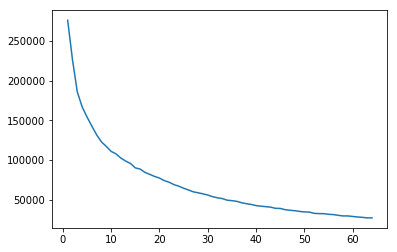

In [40]:
NCr = 64
sse = np.zeros(NCr)
for NC in tqdm(range(NCr)): # number of clusters for K-means
    kmeanse = KMeans(n_clusters=(NC+1)).fit(encoded)
    labels = kmeanse.labels_
    centers = kmeanse.cluster_centers_
    for i in range(NC+1):
        sse[NC] += np.sum((encoded[np.where(labels==i)]-centers[i])**2)
        
plt.plot(np.arange(NCr)+1,sse)


100%|██████████| 64/64 [01:45<00:00,  1.64s/it]


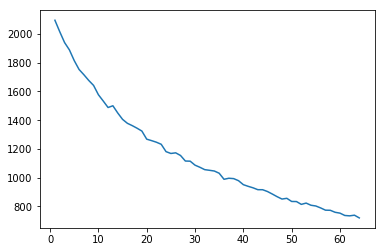

In [42]:
NCr = 64
sse = np.zeros(NCr)
for NC in tqdm(range(NCr)): # number of clusters for K-means
    kmeansb = KMeans(n_clusters=(NC+1)).fit(xviz)
    labels = kmeansb.labels_
    centers = kmeansb.cluster_centers_
    for i in range(NC+1):
        sse[NC] += np.sum((xviz[np.where(labels==i)]-centers[i])**2)
        
plt.plot(np.arange(NCr)+1,sse)